In [1]:
import numpy as np
import matplotlib.pyplot as plt

Install and import `causaltensor` package

In [2]:
#!pip install causaltensor #install the causaltensor package
import causaltensor as ct

## Data Generation

In [3]:
from causaltensor.matlib import low_rank_M0_normal
from causaltensor.matlib import iid_treatment

n1 = 100
n2 = 100
r = 2
M0 = low_rank_M0_normal(n1 = n1, n2 = n2, r = r) #low rank baseline matrix

num_treat = 5 #number of treatments
prob = 0.2
Z = []
tau = []
for k in range(num_treat):
    Z.append(iid_treatment(prob=prob, shape=M0.shape)) #treatment patterns
    tau.append(np.random.normal(loc=0, scale=1)) #treatment effects

## Empirical Experiments

In [4]:
def adding_noise(M0, Z, tau, Sigma, SigmaZ):
    num_treat = len(Z)
    O = M0 + np.random.normal(loc=0, scale=1, size=M0.shape) * Sigma #add heterogenous noise to the baseline matrix
    for k in range(num_treat):
        O += Z[k] * tau[k] + Z[k] * SigmaZ[k] * np.random.normal(loc=0, scale=1, size=M0.shape) #add heterogeneous noise to the treatment effects
    return O

In [9]:
#from causaltensor.cauest import DC_PR_with_suggested_rank
import causaltensor.cauest.DebiasConvex as DebiasConvex
from importlib import reload 

reload(DebiasConvex)

Sigma = np.random.rand(M0.shape[0], M0.shape[1])
SigmaZ = []
for k in range(num_treat):
    SigmaZ.append(np.random.rand(M0.shape[0], M0.shape[1]))

results = []
from tqdm import tqdm
for T in tqdm(range(1000)): #change 1000 to 10000 for reproducing the plot below
    O = adding_noise(M0, Z, tau, Sigma, SigmaZ)
    M, tau_hat, standard_deviation = DebiasConvex.DC_PR_with_suggested_rank(O, Z, suggest_r=r, method='non-convex') #solving a non-convex optimization to obtain M and tau
    results.append(tau_hat)
results = np.array(results)

100%|██████████| 1000/1000 [01:02<00:00, 16.05it/s]


In [10]:
print('the estimated effect ', np.mean(results, axis=0)) #the mean of the estimated treatment effects
print('the true effect ', tau) #the true treatment effects

the estimated effect  [-0.94040469  0.16472423 -0.43958008 -0.38070127  0.19369888]
the true effect  [-0.9396562238898692, 0.1642204543483711, -0.43958517431520255, -0.3818164095955779, 0.19396990181487822]


In [11]:
print('the estimated effect ', np.mean(results, axis=0)) #the mean of the estimated treatment effects
print('the true effect ', tau) #the true treatment effects

the estimated effect  [-0.94040469  0.16472423 -0.43958008 -0.38070127  0.19369888]
the true effect  [-0.9396562238898692, 0.1642204543483711, -0.43958517431520255, -0.3818164095955779, 0.19396990181487822]


### Empirical distribution of the estimated treatment effects (each sample has a different realization of noises)
The plot is obtained over 10000 samples (it cost ~5 minutes in a Macbook Pro 2021)

the empirical standard deviation 0.021659102912968384


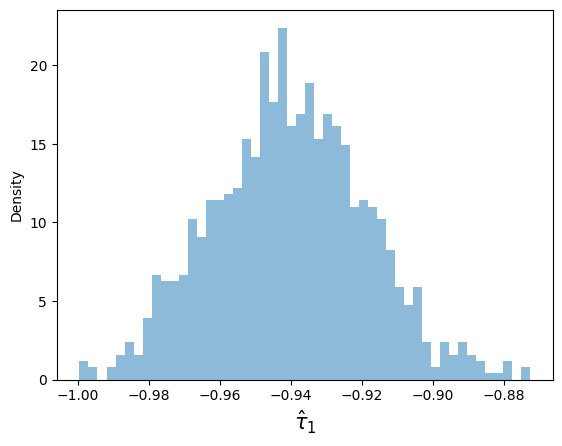

In [12]:
_ = plt.hist(results[:, 0], bins=50, density=True, alpha=0.5, label='Empirical Data')
plt.xlabel(r'$\hat{\tau}_1$', fontsize=15)
plt.ylabel('Density')
print('the empirical standard deviation', np.std(results[:, 0]))

### Compute the confidence interval given one sample

In [14]:
O = adding_noise(M0, Z, tau, Sigma, SigmaZ)
M, tau_hat, standard_deviation = DebiasConvex.DC_PR_with_suggested_rank(O, Z, suggest_r=r, method="non-convex")
print('the estimated standard deviation is ', standard_deviation[0]) #the standard deviation of estimating tau1

the estimated standard deviation is  0.02132797290495867


### Comparing the computed confidence interval and empirical distribution

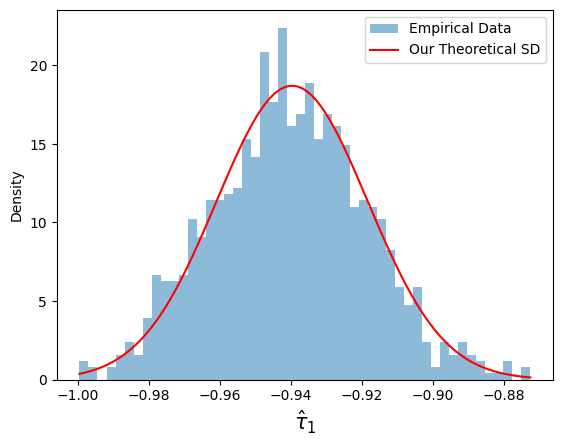

In [15]:
from scipy.stats import norm
data = results[:, 0]

# Define the Gaussian function
def gaussian(x, mean, std):
    return norm.pdf(x, loc=mean, scale=std)

# Generate x values for plotting
x = np.linspace(data.min(), data.max(), 100)

# Plot the empirical data
plt.hist(data, bins=50, density=True, alpha=0.5, label='Empirical Data')

# Plot the Gaussian fit
plt.plot(x, gaussian(x, tau[0], standard_deviation[0]), 'r-', label='Our Theoretical SD')

# Add labels and a legend
plt.xlabel(r'$\hat{\tau}_1$', fontsize=15)
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()